# Noisy two-level system

The dynamics of open quantum systems can be described with a master equation

$$\dot{\rho} = -i[H, \rho]  + \sum_k \gamma_k \big( J_k \rho J_k^\dagger - \frac{1}{2} J_k^\dagger J_k \rho - \frac{1}{2} \rho J_k^\dagger J_k \big),$$
where $J_k$ are jump operators and $\gamma_k$ corresponding jump rates. We again consider a simple two-level system Hamiltonian

$$H(t) = -\frac{\omega_0}{2}\sigma_z + \Omega(t)\sigma_x,$$

in a noisy setting by introducing relaxation through a jump operator $J_1 = \sigma_-$ and with rate $\gamma_1 = 0.01$.

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

We can add `tanh` activation function to the final layer of the neural network to bound the amplitude of our pulse $\Omega(t)$.

In [2]:
n_neurons = 4

Random.seed!(0)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 1, tanh))
θ = Vector{Float64}(initial_params(ann));

println("Number of parameters: ", length(θ))

Ω(params, t) = 3.0 * ann([t], params)[1];

Number of parameters: 53


Let's first consider our problem without the noise by minimizing the infidelity.

In [3]:
(t0, t1) = (0.0, 1.0)
cost = CostFunction((x, y) -> 1.0 - abs2(x'*y))

bs = SpinBasis(1//2)
trans = StateTransform(spindown(bs)=>spinup(bs))
H = Hamiltonian(-0.5*sigmaz(bs), [sigmax(bs)], Ω)

prob = QOCProblem(H, trans, (t0, t1), cost)
@time sol = solve(prob, θ, ADAM(0.1); maxiter=500);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
  distance:     0.000473496411684593
  constraints:  0.0


229.558013 seconds (182.89 M allocations: 13.623 GiB, 76.25% gc time, 22.85% compilation time)


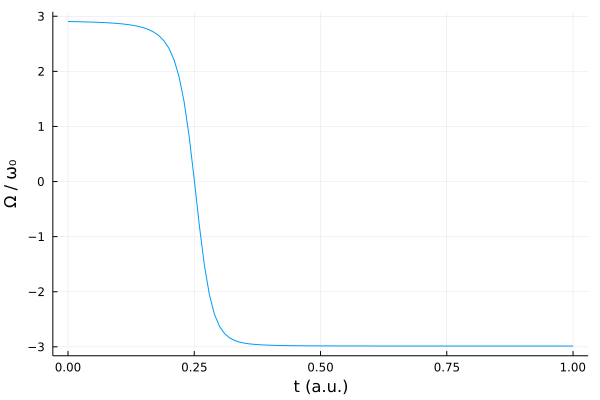

In [4]:
ts = t0:t1/100:t1

plot(ts, [Ω(sol.params, t) for t in ts])
plot!(xlabel="t (a.u.)", ylabel="Ω / ω₀", legend=false)

In order to solve the noisy problem with the existing machinery, we have to vectorize our master equation such that it takes on the form of a Schrödinger equation. We do this by applying the vectorization identity $\text{vec}(A B C) = (C^T \otimes A)\text{vec}(B)$ using `vectorize` methods.

Since our initial state is a pure state $|\psi\rangle = |\downarrow\rangle$, we can represent the overlap with the final mixed state using the formula $\langle\psi|\rho|\psi\rangle = \text{Tr}(|\psi\rangle\langle\psi|\rho)$. We can use another vectorization identity, $\text{Tr}(A^\dagger B) = \text{vec}(A)^\dagger\text{vec}(B)$, to get $\text{Tr}(|\psi\rangle\langle\psi|\rho) = \text{vec}(|\psi\rangle\langle\psi|)^\dagger\text{vec}(\rho)$. Then the infidelity can be measured with the cost function `(x, y) -> 1.0 - real(x' * y)`. Note that this infidelity measure matches the one used above for pure states.

In [5]:
costv = CostFunction((x, y) -> 1.0 - real(x'*y))

transv = vectorize(trans)
J = [sigmam(bs)]
rates = [0.01]
Hv = vectorize(H, J, rates);

Let us evolve the noisy system using the pulse optimized for the noiseless case.

In [6]:
tout, psit = master_dynamic((t0, t1), spindown(bs), H, sol.params, J, rates)
println("Infidelity: ", costv.distance(vectorize(spinup(bs)).data, vec(psit[end].data)))

Infidelity: 0.0026460929131392197


We see that the infidelity increased from roughly 0.0005 to 0.003. We can mitigate this by further optimizing our pulse on our noisy system.

In [7]:
probv = QOCProblem(Hv, transv, (t0, t1), costv)
@time solv = solve(probv, sol.params, ADAM(0.1); maxiter=500);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:00
  distance:     0.002472516421956006
  constraints:  0.0


180.761774 seconds (55.19 M allocations: 7.403 GiB, 95.99% gc time, 0.12% compilation time)


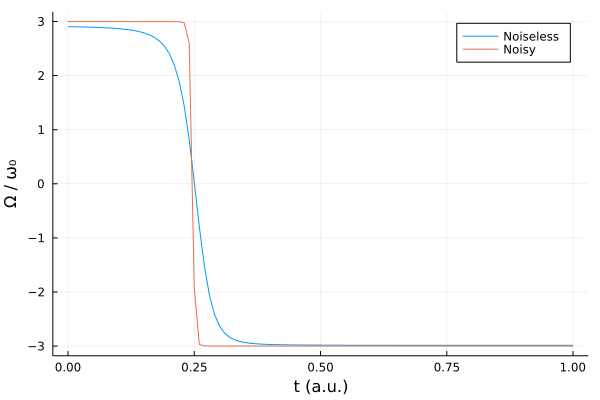

In [8]:
plot(ts, [Ω(sol.params, t) for t in ts], label="Noiseless")
plot!(ts, [Ω(solv.params, t) for t in ts], label="Noisy")
plot!(xlabel="t (a.u.)", ylabel="Ω / ω₀")

It's also interesting to note that the achieved infidelity in a noisy system is lower than the infidelity in a noiseless system for the same optimized pulse shape.

In [9]:
tout, psit = schroedinger_dynamic((t0, t1), spindown(bs), H, solv.params)
println("Noiseless infidelity: ", cost.distance(spinup(bs).data, psit[end].data))

tout, psit = master_dynamic((t0, t1), spindown(bs), H, solv.params, J, rates)
println("Noisy infidelity: ", costv.distance(vectorize(spinup(bs)).data, vec(psit[end].data)))

Noiseless infidelity: 0.00027491742741714287
Noisy infidelity: 0.0024766470915527083
